In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image
import numbergen as ng
import imagen as ig
import time
import cv2
from ssn.random_pattern import random_pattern
import numbergen as ng
import imagen as ig
import random
import imageio
from evaluation import evaluate, mitsuba_render, net_gt, net_render
import shutil

options:  Namespace(file='/home/ysheng/.local/share/jupyter/runtime/kernel-824d4e6e-17e5-4ad6-833b-f90a3d0443eb.json', ibl=None, mask=None, output=None, verbose=False, weight='../weights/group_norm_15-May-07-45-PM.pt')
Device:  cuda:0


In [136]:
plt.imsave(join('paper', 'test.png'), test_ibl)

shape: (256, 512, 3), min: 0.0, max: 1.0


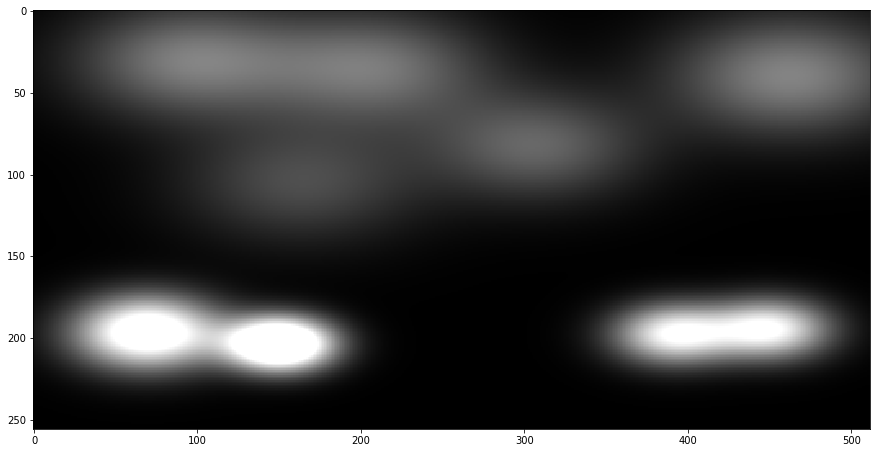

In [187]:
def convert_ibl(test_ibl):
    cur_ibl = plt.imread(test_ibl)
    show(cur_ibl)
    
    # convert to net ibl 
    cur_ibl = cur_ibl[:,:,0]
    resize_ibl = cv2.resize(cur_ibl,(32,5))
    out_ibl = np.zeros((16, 32))
    out_ibl[:5,:] = resize_ibl
    
    out_ibl = np.repeat(out_ibl[:,:,np.newaxis], 3, axis=2)
    plt.imsave('paper/converted_test.png', out_ibl)
    
cur_ibl = 'dbggggg.png'
ibl_list = ['paper/{}'.format(cur_ibl)]
for ibl in ibl_list:
    convert_ibl(ibl)

In [188]:
output = 'dbg/'
os.makedirs(output, exist_ok=True)
mask_file = '/Data_SSD/new_dataset/cache/mask/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_A/pitch_15_rot_0_mask.png'
shutil.copy(mask_file, 'dbgg')

# ibl_files = ['paper/render/1_ibl.png', 'paper/render/2_ibl.png', 'paper/render/multi_ibl.png']
ibl_files = ['paper/{}'.format(cur_ibl)]
for ibl_file in ibl_files:
    name = os.path.splitext(os.path.basename(ibl_file))[0]    
    out_name = join(output, name + "_net_gt.png")
    out_ibl = join(output, os.path.basename(ibl_file))
    shutil.copy(ibl_file, out_ibl)

    final_out_file = join(output, name + "_final.png")
    shadow_out_file = join(output, name + "_mts_shadow.png")
    mts_ibl_file = 'paper/converted_test.png'
    mitsuba_render(mask_file, mts_ibl_file, final_out_file, shadow_out_file, final=True, update_cam_param=False, real_ibl=False, write_cmd=False, skip=False)
    net_gt(mask_file, mts_ibl_file, out_name)

mitsuba finshed


shape: (256, 256, 4), min: 0.0, max: 1.0


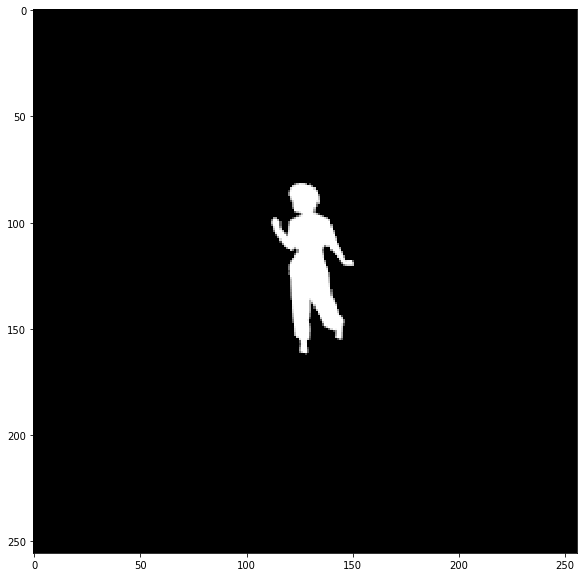

shape: (256, 256, 3), min: 0.0, max: 0.9973945617675781


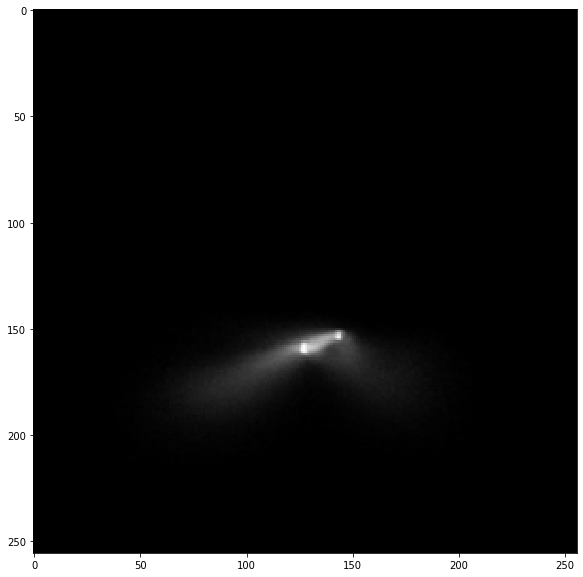

shape: (256, 256, 3), min: 0.0, max: 1.0


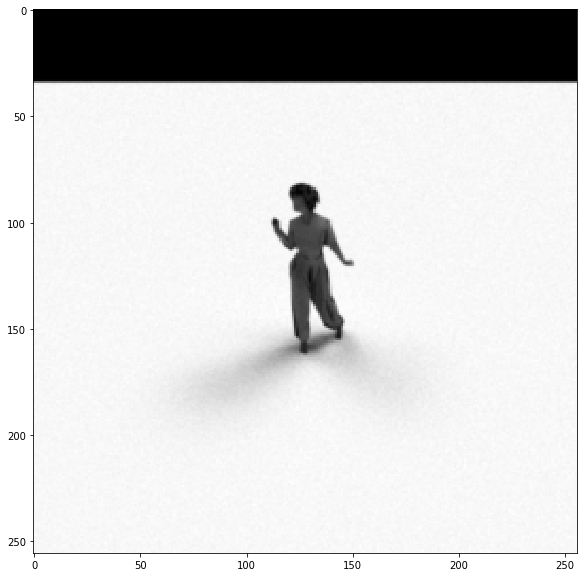

shape: (256, 256, 4), min: 0.0, max: 1.0


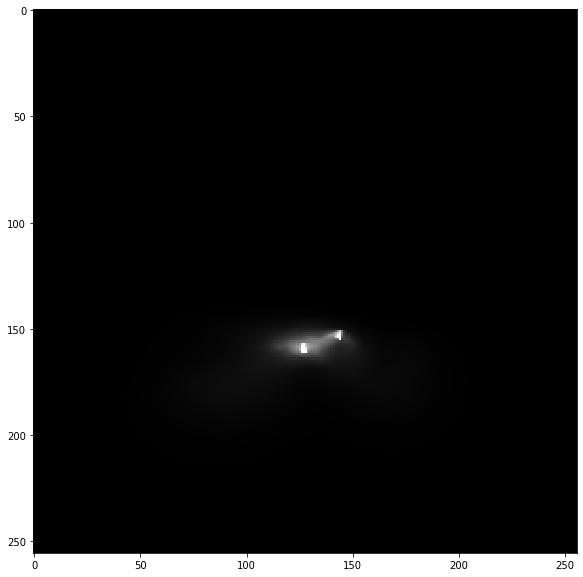

shape: (256, 256, 3), min: 0.014698898419737816, max: 1.0


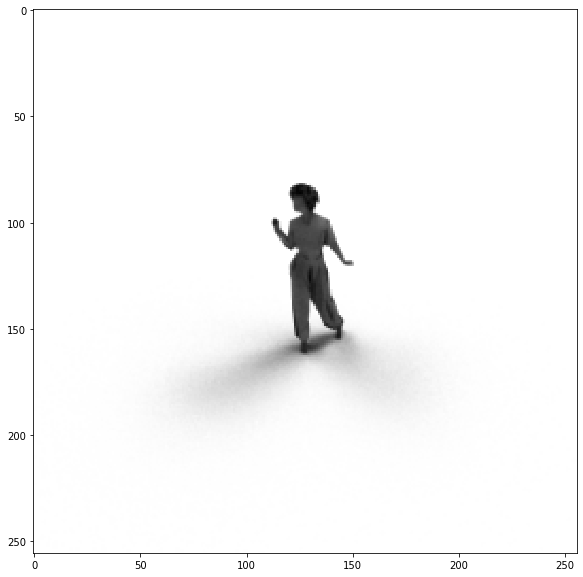

shape: (256, 256, 3), min: 0.014698898419737816, max: 1.0


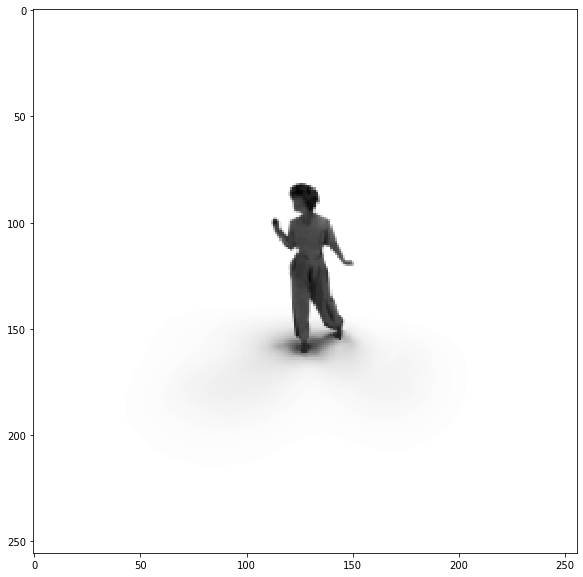

shape: (256, 512, 3), min: 0.0, max: 1.0


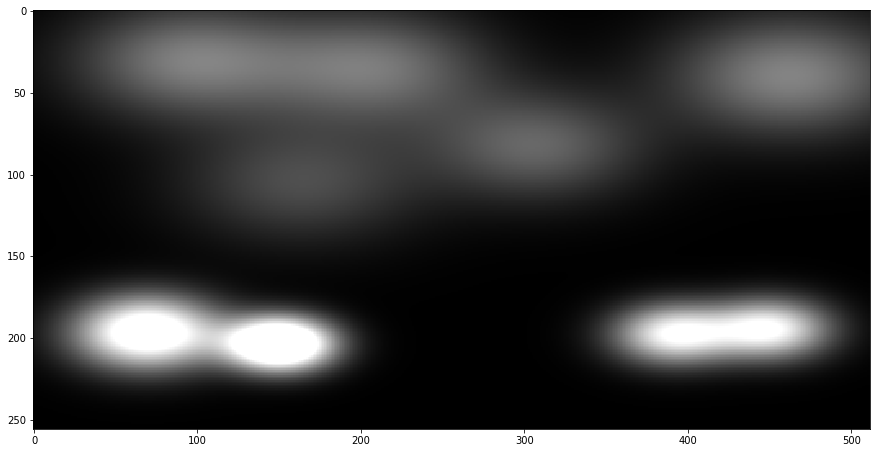

In [189]:
def composite(mask, final, shadow):
    return mask*final + (1.0-mask) * shadow

folder = 'dbg'
mask = '/Data_SSD/new_dataset/cache/mask/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_A/pitch_15_rot_0_mask.png'
prefix_set = ['{}'.format(os.path.splitext(cur_ibl)[0])]

for prefix in prefix_set:
    mts_shadow = join(folder, prefix + '_mts_shadow.exr')
    mts_final = join(folder, prefix + "_final.exr")
    net_shadow = join(folder, prefix + '_net_gt.png')
    
    mask_np = imageio.imread(mask)
    mts_shadow_np = imageio.imread(mts_shadow)
    mts_final_np = imageio.imread(mts_final)
    net_shadow_np = imageio.imread(net_shadow)
    
    mask_np = mask_np/255.0    
    net_shadow_np = net_shadow_np/255.0
    cv2.normalize(mts_final_np, mts_final_np, 0.0, 1.0, cv2.NORM_MINMAX)
    mts_final_np = mts_final_np 
    show(mask_np)
    show(1.0-mts_shadow_np)
    show(mts_final_np)
    show(net_shadow_np)
#     mts_shadow_np = mts_shadow_np/np.max(mts_shadow_np)
#     net_shadow_np = net_shadow_np/np.max(net_shadow_np)
    net_shadow_np = net_shadow_np[:,:,:3] * 1.3
    
    mts_comp = composite(mask_np[:,:,:3], mts_final_np, mts_shadow_np)
    net_shadow_np = 1.0 - net_shadow_np[:,:,:3]
    nt_gt_comp = composite(mask_np[:,:,:3], mts_final_np, net_shadow_np[:,:,:3])
    
    show(mts_comp)
    show(nt_gt_comp)
    mts_comp = np.clip(mts_comp, 0.0, 1.0)
    nt_gt_comp = np.clip(nt_gt_comp, 0.0, 1.0)
    plt.imsave(join('paper', prefix + '_mts_comp.png'), mts_comp)
    plt.imsave(join('paper', prefix + '_netgt_comp.png'), nt_gt_comp)
    
    cur_ibl = join('paper', prefix + '.png')
    # padding to center 
    cur_ibl_np = plt.imread(cur_ibl)
    show(cur_ibl_np)

In [3]:
def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

def get_fname(fpath):
    return os.path.splitext(os.path.basename(fpath))[0]

In [4]:
pattern_generator = random_pattern()

def show(img, title='',cmap=None): 
    print('shape: {}, min: {}, max: {}'.format(img.shape, np.min(img), np.max(img)))
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [5]:
us_dict={1:10, 2:10, 4:8, 10:4,20:2,30:2,40:2,50:2}
output_folder = 'user_study'
os.makedirs(output_folder, exist_ok=True)

def to_ibl(img):
    ibl = cv2.resize(img, (32, 5))
    output_ibl = np.zeros((16,32))
    output_ibl[:5,:] = ibl
    output_ibl = output_ibl/np.max(output_ibl)
    return output_ibl
    
for key,value in us_dict.items():
    print(key, value)
    for i in range(value):
        sampled_ibl = pattern_generator.get_pattern(key, size=0.12)
        sampled_ibl = to_ibl(sampled_ibl)
#         sampled_ibl = np.repeat(sampled_ibl[:,:,np.newaxis], 3, axis=2)
        
        sampled_ibl = np.repeat(sampled_ibl[:, :, np.newaxis], 3, axis=2)
        save_path = join(output_folder, '{}_{}_ibl.png'.format(key, i))
        plt.imsave(save_path, sampled_ibl, cmap='gray')

1 10
2 10
4 8
10 4
20 2
30 2
40 2
50 2


In [6]:
testing_ibl_folder = '/home/ysheng/Dataset/ibls/pattern/'
high_reso_testing_ibl_folder = '/home/ysheng/Dataset/ibls/high_pattern/'
testing_real_ibl_folder = '/home/ysheng/Dataset/ibls/real/'
model_folder = '/home/ysheng/Dataset/models/'
test_model_folder='/home/ysheng/Dataset/test_models/'
result_folder = '/home/ysheng/Dataset/evaluation'

In [7]:
model_lists = get_files(test_model_folder)
test_model_list = []
for m in model_lists:
    model_name = os.path.splitext(os.path.basename(m))[0]
    test_model_list.append(model_name)

# test_model_list = random.sample(test_model_list, k=10, )
print(len(test_model_list))
print(test_model_list)

mask_dict = dict()
mask_root = '/home/ysheng/Dataset/new_dataset/cache/test_mask/'
sample_list = []
for model in test_model_list:
    mask_folder = join(mask_root, model)
    masks = get_files(mask_folder)
    filterd_masks = []
    for m in masks:
        if m.find('.png') != -1:
            filterd_masks.append(m)
    
    sample_list += filterd_masks

20
['notsimulated_combine_female_genesis8_bridget8_toulouse_cwoutfit_FEP_Pose_043_Genesis_8_Female', 'combine_female_genesis3_basic_nohair_nomad_Fashion_Model_Pose_06', 'notsimulated_combine_female_genesis8_gabriela8_riley_tcoset_Miss_Shang_06', 'notsimulated_combine_female_genesis8_basic_blair_autumnaloutfit_FEP_Pose_013_Genesis_8_Female', 'simulated_combine_female_genesis8_basic_wildwind_bardot_FEP_Pose_118_Genesis_8_Female', 'simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B', 'notsimulated_combine_female_genesis8_gabriela8_riley_tcoset_FEP_Pose_066_Genesis_8_Female', 'combine_male_genesis2_surferguy_nohair_nocloth_Standing_Base_16', 'simulated_combine_male_genesis8_basic_blair_cityboy_Altern8_Lee_8_-_Pose_11_B', 'simulated_combine_female_genesis8_basic_blair_mdscasualdressfullpreset01_CDIBridget8_StandB', 'notsimulated_combine_female_genesis8_bridget8_toulouse_cwoutfit_FEP_Pose_079_Genesis_8_Female', 'simulated_combine_female_genesis8_missshang_hywavybob_x

In [8]:
print(len(sample_list))

random.seed(19920208)
ibl_folder = 'user_study'
us_ibls = get_files(ibl_folder)
print(len(us_ibls))
np.random.shuffle(us_ibls)

us_mask = random.sample(sample_list, k=len(us_ibls))
print(len(us_mask))

np.random.shuffle(us_mask)

# prepare mitsuba result
user_study_result = 'user_study_result'
os.makedirs(user_study_result, exist_ok=True)

300
40
40


In [ ]:
for i in range(len(us_ibls)):
    ibl, mask = us_ibls[i], us_mask[i]
    ibl_np, mask_np = plt.imread(ibl), plt.imread(mask)
#     show(ibl_np)
#     show(mask_np)
    
    ibl_name, mask_name = get_fname(ibl), get_fname(mask)
    prefix = '{}_{}'.format(ibl_name, mask_name)
    final_out, shadow_out = join(user_study_result, '{}_final.exr'.format(prefix)), join(user_study_result, '{}_shadow.exr'.format(prefix))
    
    mitsuba_render(mask, ibl, final_out, shadow_out, real_ibl=False, write_cmd=False, update_cam_param=True, skip=False)
    final_np, shadow_np = imageio.imread(final_out), imageio.imread(shadow_out)
    cv2.normalize(final_np,final_np, 0.0, 1.0, cv2.NORM_MINMAX)
#     show(final_np)
#     show(shadow_np)

In [85]:
# prepare net renderign result
for i in tqdm(range(len(us_ibls))):
    ibl, mask = us_ibls[i], us_mask[i]
    
    ibl_np, mask_np = plt.imread(ibl), plt.imread(mask)
    

    ibl_name, mask_name = get_fname(ibl), get_fname(mask)
    prefix = '{}_{}'.format(ibl_name, mask_name)
    pred_out = join(user_study_result, '{}_predict.png'.format(prefix))
    
    net_render(mask, ibl, pred_out)
    pred_np = plt.imread(pred_out)

#     show(ibl_np)
#     show(mask_np)
#     show(pred_np)
    
    plt.imsave(join(user_study_result, '{}.png'.format(prefix)), mask_np)

100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


In [9]:
 # final scaling and compositing
final_us_folder = 'user_study_result'
final_files = get_files(final_us_folder)
print('there are {} files'.format(len(final_files)))
prefix_set = set()
for f in final_files:
    fname = os.path.splitext(os.path.basename(f))[0]
    if fname.find('predict') != -1:
        prefix = fname[:fname.find('_mask')]
        prefix_set.add(prefix)
    
print('samples: {}'.format(len(prefix_set)))

there are 280 files
samples: 40


In [10]:
final_samples = random.sample(list(prefix_set), k=40)
print('final samples: {}'.format(len(final_samples)))

final samples: 40


In [35]:
def show2(img1, t1, img2, t2):
    plt.figure(figsize=(20,15))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(t1)
    
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(t2)

In [60]:
out_folder = 'final_us'

os.makedirs(out_folder, exist_ok=True)

def composite(mask, final, mts_shadow, predict_shadow):
    mask = mask[:,:,:3]
    mts_shadow = 1.0 - mts_shadow
    
    predict_shadow = 1.0 - predict_shadow
    mts_comp, pred_comp = np.copy(mts_shadow), np.copy(predict_shadow)
    
    mts_comp[np.where(mask>1e-3)] = final[np.where(mask>1e-3)]
    pred_comp[np.where(mask>1e-3)] = final[np.where(mask>1e-3)]
    
    return mts_comp, pred_comp

counter = 0
final_us_folder = 'user_study_result' 
for fs in tqdm(final_samples):
    
    final, mts_shadow, predict = fs + '_mask_final.exr', fs + '_mask_shadow.exr', fs + '_mask_predict.png'
    final, mts_shadow, predict = join(final_us_folder, final), join(final_us_folder, mts_shadow), join(final_us_folder, predict) 
        
    final_np, mts_shadow_np, predict_np = imageio.imread(final), 1.0- imageio.imread(mts_shadow), plt.imread(predict)
    predict_np = predict_np[:,:,:3]
    cv2.normalize(final_np,final_np, 0.0, 1.0, cv2.NORM_MINMAX)
    mts_shadow_np = mts_shadow_np/np.max(mts_shadow_np)
    
    max_scale = 0.4
    spredict_np = predict_np * (1 + max_scale)
    spredict_np = np.clip(spredict_np, 0.0, 1.0)

    mask = fs + '_mask.png'
    mask_np = plt.imread(join(final_us_folder, mask))

    mts_comp, pred_comp = composite(mask_np, final_np, mts_shadow_np, spredict_np)
    mts_comp = np.clip(mts_comp, 0.0, 1.0)
    pred_comp = np.clip(pred_comp, 0.0, 1.0)
    
    plt.imsave(join(out_folder, '{:03d}_mts.png'.format(counter)), mts_comp)
    plt.imsave(join(out_folder, '{:03d}_prd.png'.format(counter)), pred_comp)
    
    counter += 1













  0%|          | 0/40 [00:00<?, ?it/s]











  2%|▎         | 1/40 [00:00<00:04,  9.41it/s]

1.4
1.4














  5%|▌         | 2/40 [00:00<00:04,  9.34it/s]











  8%|▊         | 3/40 [00:00<00:03,  9.32it/s]

1.4
1.4














 10%|█         | 4/40 [00:00<00:03,  9.28it/s]











 15%|█▌        | 6/40 [00:00<00:03,  9.74it/s]

1.4
1.4
1.4














 20%|██        | 8/40 [00:00<00:02, 10.68it/s]











 22%|██▎       | 9/40 [00:00<00:02, 10.43it/s]

1.4
1.4
1.4














 25%|██▌       | 10/40 [00:00<00:03,  9.77it/s]











 30%|███       | 12/40 [00:01<00:02,  9.70it/s]

1.4
1.4














 35%|███▌      | 14/40 [00:01<00:02,  9.82it/s]

1.4
1.4
1.4














 38%|███▊      | 15/40 [00:01<00:02,  9.68it/s]











 40%|████      | 16/40 [00:01<00:02,  9.74it/s]

1.4
1.4
1.4














 45%|████▌     | 18/40 [00:01<00:02,  9.97it/s]











 48%|████▊     | 19/40 [00:01<00:02,  9.67it/s]

1.4
1.4














 52%|█████▎    | 21/40 [00:02<00:01,  9.63it/s]

1.4
1.4














 55%|█████▌    | 22/40 [00:02<00:01,  9.64it/s]











 60%|██████    | 24/40 [00:02<00:01,  9.94it/s]

1.4
1.4
1.4














 65%|██████▌   | 26/40 [00:02<00:01,  9.79it/s]

1.4
1.4














 70%|███████   | 28/40 [00:02<00:01,  9.87it/s]











 72%|███████▎  | 29/40 [00:02<00:01,  9.87it/s]

1.4
1.4














 75%|███████▌  | 30/40 [00:03<00:01,  9.73it/s]

1.4
1.4














 78%|███████▊  | 31/40 [00:03<00:00,  9.38it/s]











 80%|████████  | 32/40 [00:03<00:00,  9.41it/s]

1.4
1.4
1.4














 85%|████████▌ | 34/40 [00:03<00:00,  9.61it/s]











 88%|████████▊ | 35/40 [00:03<00:00,  9.45it/s]

1.4
1.4














 92%|█████████▎| 37/40 [00:03<00:00,  9.67it/s]

1.4
1.4
1.4














 98%|█████████▊| 39/40 [00:03<00:00,  9.88it/s]











100%|██████████| 40/40 [00:04<00:00,  9.90it/s]

1.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.0


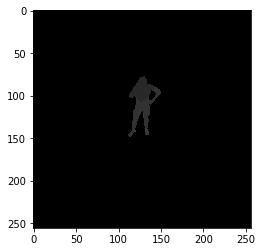

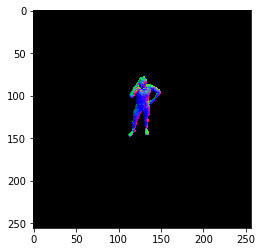

In [8]:
depth_file = '/home/ysheng/Documents/jianming/cpu_hard_shadow_renderer/cpu_hard_shadow_renderer_src/build/output/lamp/pitch_35_rot_0_depth.png'
mask_file = '/home/ysheng/Documents/jianming/cpu_hard_shadow_renderer/cpu_hard_shadow_renderer_src/build/output/lamp/pitch_35_rot_0_mask.png'

depth_img = plt.imread(depth_file)
mask_img = plt.imread(mask_file)

print(np.min(depth_img), np.max(depth_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


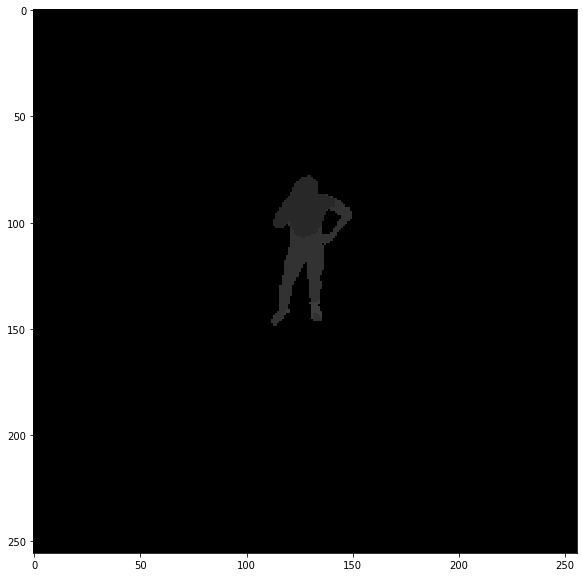

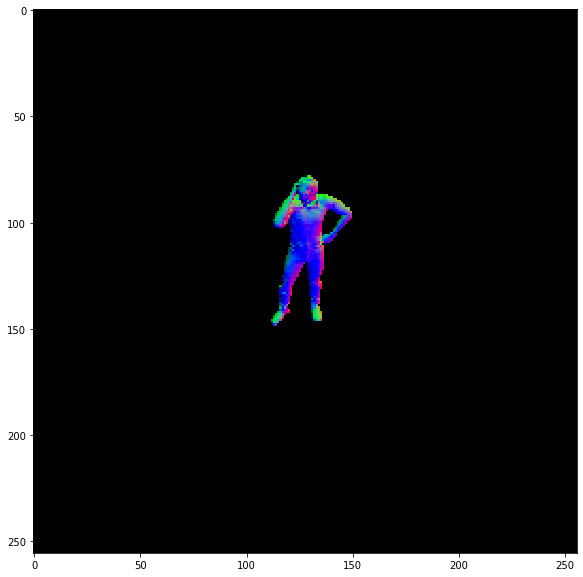

In [13]:
def show(img, cmap=None):
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.show()
    
show(depth_img * 10.0)
show(mask_img)

In [35]:
# sobel_filter = np.zeros([[1,0,-1],[2,0,-2], [1,0,-1]])
from scipy import ndimage
from scipy import ndimage as ndi
from skimage import feature

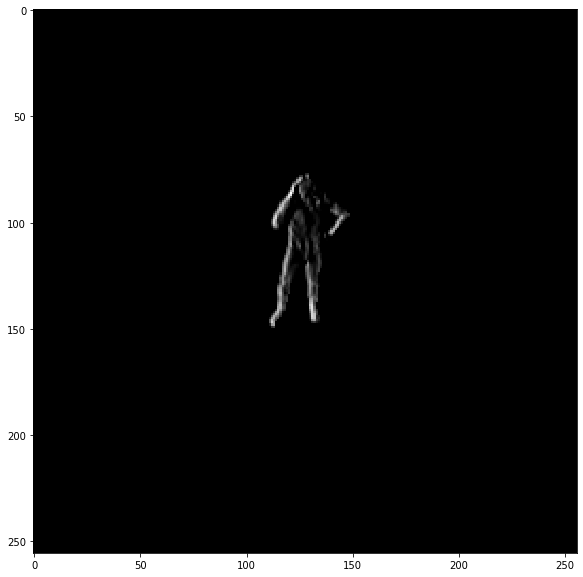

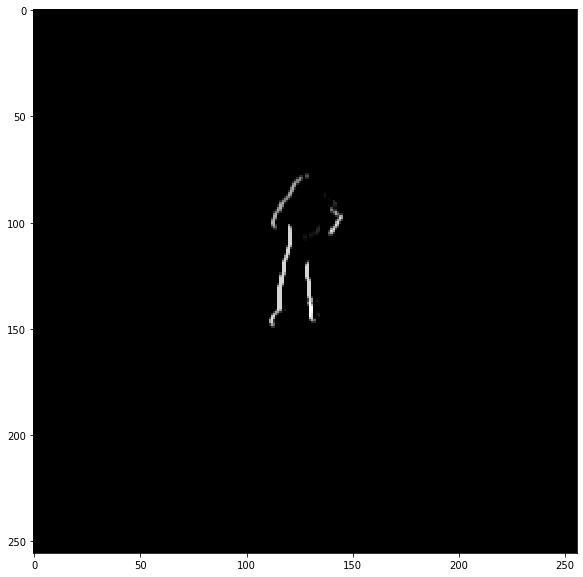

In [33]:
gray = (mask_img[:,:,0] + mask_img[:,:,1] + mask_img[:,:,2]) / 3.0
gray_depth = (depth_img[:,:,0] + depth_img[:,:,1] + depth_img[:,:,2]) / 3.0

normal_sobel_edges = ndimage.sobel(gray)  
depth_sobel_edges = ndimage.sobel(gray_depth)

normal_sobel_edges = normal_sobel_edges/np.max(normal_sobel_edges)
sobel_edges = sobel_edges/np.max(sobel_edges)

normal_sobel_edges[np.where(normal_sobel_edges <= -0.0)] = 0.0
sobel_edges[np.where(sobel_edges <= -0.0)] = 0.0

# sobel_edges[np.where(sobel_edges <= 0)] = 0.0

show(normal_sobel_edges, cmap='gray')
show(sobel_edges, cmap='gray')

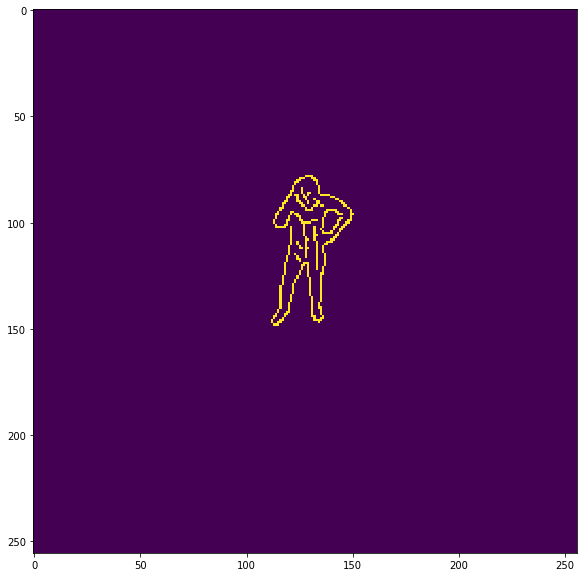

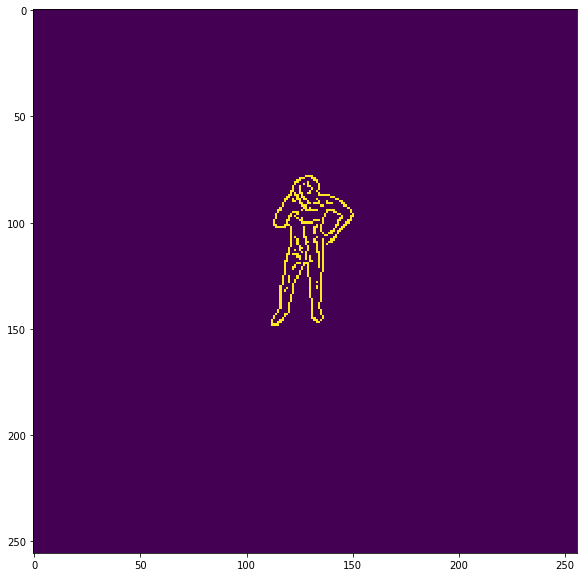

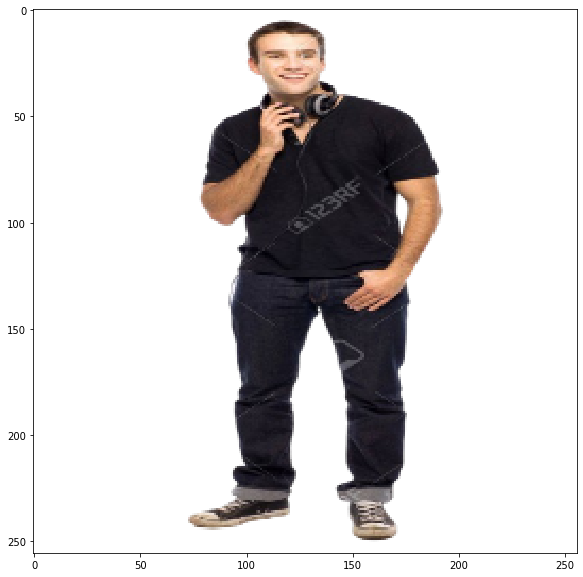

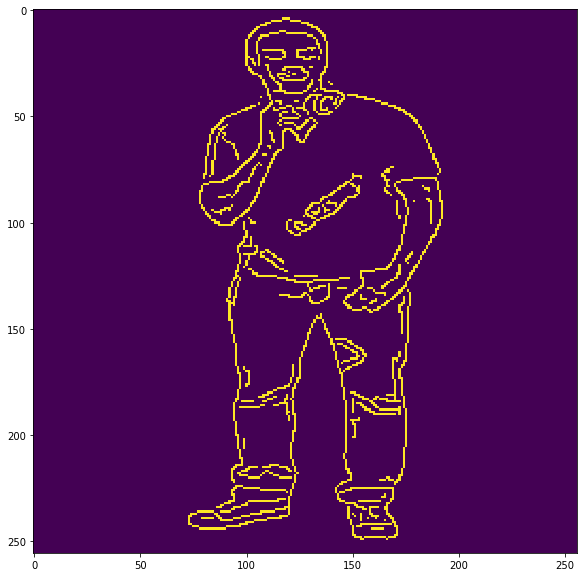

In [49]:
img = plt.imread('/home/ysheng/Documents/adobe_shadow_net/real_human/10944340-young-man-standing.png')
# img = img[:,:,0] + img[:,:,1] + img[:,:,2]

img = cv2.resize(img, (256,256))

edges1 = feature.canny(gray)
edges2 = feature.canny(gray, sigma=1e-7)

edges3 = feature.canny(img[:,:,0])

show(edges1)
show(edges2)
show(img)
show(edges3)